(COMPPARALELOCPUSSMC)=

# 5.4 Cómputo en paralelo usando CPUs en un sistema de memoria compartida (SMC)

```{admonition} Notas para contenedor de docker:

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

`docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_optimizacion_2 -p 8888:8888 -p 8787:8787 -d palmoreck/jupyterlab_optimizacion_2:3.0.0`

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

`docker stop jupyterlab_optimizacion_2`

Documentación de la imagen de docker `palmoreck/jupyterlab_optimizacion_2:3.0.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/optimizacion_2).

```

---

Nota generada a partir de [liga1](https://www.dropbox.com/s/oauifmx3e19ofyq/2.3.Sistemas_de_memoria_compartida_Pthreads.pdf?dl=0), [liga2](https://www.dropbox.com/s/vcxbrqkk6x946d7/2.4.Sistemas_de_memoria_compartida_openMP.pdf?dl=0), [liga3](https://www.dropbox.com/s/v4ub0p3ndf7w1p0/2.2.Sistemas_de_memoria_distribuida_MPI.pdf?dl=0)

```{admonition} Al final de esta nota el y la lectora:
:class: tip

*

```

Se presentan códigos y sus ejecuciones en una máquina `m4.16xlarge` de la nube de [AWS](https://aws.amazon.com/). Se utilizó la AMI `opt2-aws-educate-openblas-02-05-2021` de la región `us-east-1` (Virginia) para reproducibilidad de resultados. Tal AMI se construyó a partir de una AMI `ubuntu 20.04 - ami-042e8287309f5df03` con el [script_profiling_and_BLAS.sh](https://github.com/palmoreck/scripts_for_useful_tools_installations/blob/main/AWS/ubuntu_20.04/optimizacion_2/script_profiling_and_BLAS.sh)

````{admonition} Comentario

Si se utiliza la *AMI* `opt2-aws-educate-openblas-04-04-2021` colocar en `User data` el siguiente *script*:

```bash

#!/bin/bash
##variables:
region=us-east-1 #make sure instance is in Virginia
name_instance=OpenBLAS
USER=ubuntu
##System update
apt-get update -yq
##Tag instance
INSTANCE_ID=$(curl -s http://instance-data/latest/meta-data/instance-id)
PUBLIC_IP=$(curl -s http://instance-data/latest/meta-data/public-ipv4)
sudo -H -u $USER bash -c "/home/$USER/.local/bin/aws ec2 create-tags --resources $INSTANCE_ID --tag Key=Name,Value=$name_instance-$PUBLIC_IP --region=$region"
sudo -H -u $USER bash -c "cd / && /home/$USER/.local/bin/jupyter lab --ip=0.0.0.0 --no-browser --config=/home/$USER/.jupyter/jupyter_notebook_config.py &"

```

````

La máquina `m4.16xlarge` tiene las siguientes características:

In [1]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          64
On-line CPU(s) list:             0-63
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:                        1
CPU MHz:                         2213.083
CPU max MHz:                     3000.0000
CPU min MHz:                     1200.0000
BogoMIPS:                        4600.00
Hypervisor vendor:               Xen
Virtualization type:             full
L1d cache:                       1 MiB
L1i cache:                       1 MiB
L2 cache:                        8

In [2]:
%%bash
sudo lshw -C memory

  *-firmware
       description: BIOS
       vendor: Xen
       physical id: 0
       version: 4.11.amazon
       date: 08/24/2006
       size: 96KiB
       capabilities: pci edd
  *-memory
       description: System Memory
       physical id: 1000
       size: 256GiB
       capabilities: ecc
       configuration: errordetection=multi-bit-ecc
     *-bank:0
          description: DIMM RAM
          physical id: 0
          slot: DIMM 0
          size: 16GiB
          width: 64 bits
     *-bank:1
          description: DIMM RAM
          physical id: 1
          slot: DIMM 1
          size: 16GiB
          width: 64 bits
     *-bank:2
          description: DIMM RAM
          physical id: 2
          slot: DIMM 2
          size: 16GiB
          width: 64 bits
     *-bank:3
          description: DIMM RAM
          physical id: 3
          slot: DIMM 3
          size: 16GiB
          width: 64 bits
     *-bank:4
          description: DIMM RAM
          physical id: 4
          slot: DIMM

In [3]:
%%bash
uname -ar #r for kernel, a for all

Linux ip-10-0-0-84 5.4.0-1038-aws #40-Ubuntu SMP Fri Feb 5 23:50:40 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux


```{admonition} Observación
:class: tip

En la celda anterior se utilizó el comando de *magic* `%%bash`. Algunos comandos de *magic* los podemos utilizar también con `import`. Ver [ipython-magics](https://ipython.readthedocs.io/en/stable/interactive/magics.html#)

```

## Sistemas de memoria compartida (SMC)

Un SMC en general se ve como el siguiente dibujo:

<img src="https://dl.dropboxusercontent.com/s/ao3if8tzwsvzfi7/shared_memory_sistems.png?dl=0" heigth="500" width="500">

El dibujo anterior es un SMC con acceso uniforme a la memoria ([UMA](https://en.wikipedia.org/wiki/Uniform_memory_access)), esto es, cada proceso o *thread* creado en el procesador o *core* accede con las mismas velocidades a la memoria.

La **comunicación** en este tipo de sistemas depende si se utilizan procesos o *threads* ya que aunque los procesos generados por un proceso principal tienen acceso a la memoria, los cambios/actualizaciones que haga uno de ellos a una variable no lo llegan a ver los otros procesos. Esto es distinto con los *threads* dado que un cambio que realice un *thread* en una variable sí lo pueden ver los otros *threads*. Lo anterior se debe a las distintas direcciones de memoria que utilizan los procesos vs la misma dirección de memoria que utilizan los *threads*.

Recuérdese que se crean *threads* a partir de un proceso principal, realizan *fork*, y una vez que terminan su ejecución se unen nuevamente, realizan *join*, esto es el *threading*.

<img src="https://dl.dropboxusercontent.com/s/0vnjfdk7fo62m8h/threading.png?dl=0" heigth="400" width="400">

Ver {ref}`Threading o Hyperthreading <THREADINGHYPER>`.

```{admonition} Observación
:class: tip

Hay paqueterías que crean subprocesos a partir de un proceso principal en lugar de *threads*. En este caso en lugar de un *fork* se realiza un *spawn*. Los subprocesos pueden ver cambios a variables hechos por otros. 

Ver [Contexts and start methods](https://docs.python.org/3.9/library/multiprocessing.html#contexts-and-start-methods) y [difference between threadpool vs pool in python multiprocessing](https://stackoverflow.com/questions/46045956/whats-the-difference-between-threadpool-vs-pool-in-python-multiprocessing-modul) para diferencias entre *fork* y *spawn*.

```

```{admonition} Definición

Las variables que pueden ser accesadas por todos los *threads* en un SMC se les nombra **variables compartidas**.

```

Trabajar sobre SMC tiene ventajas y desventajas. Una ventaja es facilidad de comunicación y una desventaja es la **coordinación** para ejecutar instrucciones. Por ejemplo, con variables compartidas se puede realizar la comunicación entre los *threads*, sin embargo, para el uso de tales variables por diferentes *threads* debemos crear candados, *locks*. Lo anterior surge pues si un *thread* con etiqueta $1$ accede a una variable compartida, otro *thread* con etiqueta $2$, no podrá utilizarla hasta que el thread $1$ finalice de usarla. Ver [Thread Safety](https://en.wikipedia.org/wiki/Thread_safety) y [Race Condition](https://en.wikipedia.org/wiki/Race_condition#Computing).

```{admonition} Definición

En una *race condition* múltiples *threads* intentan acceder a un recurso compartido, al menos uno de los accesos resulta en una modificación al recurso y posteriormente los siguientes accesos pueden no ver la modificación. A la sección del código que causa la *race condition* se le nombra *critical section*. Las *critical sections* se ejecutan con código secuencial o con *locks* para evitar las *race conditions*.

```

```{admonition} Comentarios

* Para crear procesos o *threads* en los lenguajes de programación de *C, Python* o *R*, utilizamos las librerías, API's o extensiones vía paquetes a tales lenguajes. Lo anterior se debe a que *C, Python* y *R* en sus implementaciones más utilizadas o estándar, fueron diseñados con el propósito de utilizarse sobre sistemas con un sólo procesador. En distintas implementaciones de los lenguajes hay soporte para SMC. 

* Ejemplos de máquinas con SMC son las laptops, los celulares, máquinas de escritorio con más de un *core*.

* Otro tipo de SMC se puede representar con el siguiente dibujo:

<img src="https://dl.dropboxusercontent.com/s/dqwdqdxiecj91vy/shared_memory_systems_2.png?dl=0" heigth="500" width="500">

en el que los procesos o *threads* pueden acceder a la memoria en una forma no uniforme [(NUMA)](https://en.wikipedia.org/wiki/Non-uniform_memory_access). Una de las diferencias que se tienen entre un NUMA y un UMA es la tasa de transferencia de datos para *cores* que están más cercanos a una memoria.

* Un sistema de memoria distribuida (SMD) tiene una conexión, por ejemplo vía una *network*, entre pares de *core-memoria* y en general se ve como el siguiente dibujo:

<img src="https://dl.dropboxusercontent.com/s/iky7af1m3dcj3e0/distributed_memory_systems.png?dl=0" heigth="600" width="600">

La memoria en un SMD asociada al *core* sólo puede ser accesada por éste y es inaccesible a los demás *cores*, esto es, se tiene una memoria "privada". Lo anterior contrasta con los SMC en los que todos los *cores* accesan a una memoria compartida. En un SMD el cómputo distribuido crea múltiples procesos a partir de un proceso principal. En un SMC el cómputo paralelo crea múltiples procesos o *threads*. Un ejemplo de un SMD es un clúster de máquinas. Cada máquina en el clúster puede ser un SMC y por tanto los procesos en cada máquina tienen la capacidad de crear procesos o *threads*. En este caso se tiene un sistema híbrido SMD y SMC. Un programa diseñado para ejecutarse en un SMD puede ejecutarse en un SMC pues se divide su memoria de forma lógica en espacios de memoria privados para los *threads*.

```

## [OpenMP](http://www.openmp.org/)

Es una extensión al lenguaje *C* y es una API para cómputo en paralelo en un sistema de memoria compartida, *aka, shared memory parallel programming* con CPUs. Lo anterior *OpenMP* lo posibilita con el *threading*.

* Las siglas *MP* se refieren a *multiprocessing*, un sinónimo de *shared memory parallel computing*. *OpenMP* se utiliza en un SMC por lo que cada *thread* tiene acceso a la memoria.

* Algunas características de *OpenMP* son:

    * Paralelización de ciclos *for* secuenciales en los que las iteraciones son independientes una de la otra de forma simple.

    * Paralelización de tareas y sincronización explícita de *threads*.

```{margin}

Las directivas son instrucciones que indican al [preprocesador](https://en.wikipedia.org/wiki/Preprocessor) (vía la compilación) que ejecutaremos una instrucción que no se encuentra en la especificación básica del lenguaje C. Ver [C preprocessor](https://en.wikipedia.org/wiki/C_preprocessor).

```

* Provee **directivas** vía `#pragma omp` para el cómputo en paralelo en un SMC.

```{admonition} Comentario

Los `pragma` se utilizan para extender la funcionalidad de *C* pues no son parte de su especificación básica. Las versiones más recientes del compilador `gcc` soportan a los `pragma` y todas las *preprocessor directives* son por *default* de longitud una línea.

Ver [pragmas](https://gcc.gnu.org/onlinedocs/cpp/Pragmas.html).

```

### Directiva parallel

### Ejemplo

`hello_world_omp.c`

In [1]:
%%file hello_world_omp.c
#include<stdio.h>
#include<stdlib.h>
#include<omp.h> 

void Hello(void);
int main(){

    #pragma omp parallel
        Hello();
    
    return 0;
}

void Hello(void){
    int my_rank = omp_get_thread_num(); 
    int num_th = omp_get_num_threads(); 
    printf("Hola del thread: %d de %d\n", my_rank, num_th);
}


Writing hello_world_omp.c


In [2]:
%%bash
gcc -Wall -fopenmp hello_world_omp.c -o hello_world_omp.out

In [3]:
%%bash
./hello_world_omp.out

Hola del thread: 60 de 64
Hola del thread: 9 de 64
Hola del thread: 6 de 64
Hola del thread: 13 de 64
Hola del thread: 44 de 64
Hola del thread: 15 de 64
Hola del thread: 12 de 64
Hola del thread: 16 de 64
Hola del thread: 18 de 64
Hola del thread: 14 de 64
Hola del thread: 62 de 64
Hola del thread: 17 de 64
Hola del thread: 45 de 64
Hola del thread: 48 de 64
Hola del thread: 23 de 64
Hola del thread: 55 de 64
Hola del thread: 24 de 64
Hola del thread: 42 de 64
Hola del thread: 26 de 64
Hola del thread: 49 de 64
Hola del thread: 0 de 64
Hola del thread: 29 de 64
Hola del thread: 50 de 64
Hola del thread: 34 de 64
Hola del thread: 53 de 64
Hola del thread: 47 de 64
Hola del thread: 19 de 64
Hola del thread: 39 de 64
Hola del thread: 38 de 64
Hola del thread: 36 de 64
Hola del thread: 33 de 64
Hola del thread: 37 de 64
Hola del thread: 43 de 64
Hola del thread: 59 de 64
Hola del thread: 28 de 64
Hola del thread: 21 de 64
Hola del thread: 46 de 64
Hola del thread: 27 de 64
Hola del thread

````{admonition} Comentarios

* `omp.h` es un *header file* con prototipos y definiciones de macros para uso de la librería de funciones y macros de *OpenMP*.

* La función `Hello` será ejecutada por los *threads*.

* La función `omp_get_thread_num` da el *rank* asignado por el *run time system* a cada *thread*.

* Con la función `omp_get_num_threads` se obtiene el número de *threads* que realizaron un *fork* del *thread* principal.

* Obsérvese que para la compilación se utilizó la *flag* `-fopenmp` para soporte de *OpenMP*.

* Dependiendo del número de *cores* de nuestro sistema tendremos diferentes número de `printf`'s.

* Lo que continúa a la línea de `#pragma omp parallel` es un *structured block*, esto es, un *statement* o conjunto de *statements* que tienen un punto de entrada y un punto de salida. En el caso anterior sólo se llama a la función `Hello`. 

* No se permiten *statements* como el siguiente:

```C
#pragma omp parallel

if(...) break;

```

ni tampoco:
    
```C
#pragma omp parallel

    {
        if(variable == valor) return 1;
        return -1;
    }

```

````

A continuación de la directiva `parallel` podemos usar diferentes tipos de *clauses*. Una *clause* en *OpenMP* es un texto que modifica una directiva. Por ejemplo, podemos usar la *clause* `num_threads` para especificar el número de threads que ejecutarán el *structured block*.

### `num_threads` *clause*

### Ejemplo

`hello_world_omp_num_threads.c`

In [4]:
%%file hello_world_omp_num_threads.c
#include<stdio.h>
#include<stdlib.h>
#include<omp.h> 

void Hello(void); 
int main(){
    int n_threads = 5;
    #pragma omp parallel num_threads(n_threads) 
        Hello();
    
    return 0;
}

void Hello(void){
    int my_rank = omp_get_thread_num(); 
    int num_th = omp_get_num_threads(); 
    printf("Hola del thread: %d de %d\n", my_rank, num_th);
}


Writing hello_world_omp_num_threads.c


In [5]:
%%bash
gcc -Wall -fopenmp hello_world_omp_num_threads.c -o hello_world_omp_num_threads.out

In [6]:
%%bash
./hello_world_omp_num_threads.out

Hola del thread: 0 de 5
Hola del thread: 4 de 5
Hola del thread: 1 de 5
Hola del thread: 3 de 5
Hola del thread: 2 de 5


### *Reduction clause* 

*OpenMP* provee la *reduction clause* para aplicar la operación de suma (operador binario) a cada resultado calculado de un *thread* de forma repetida y almacenar en una variable la respuesta.

Nombramos *reduction variable* a la variable que almacenará los resultados intermedios calculados por cada *thread* y *reduction operator* a la operación binaria (por ejemplo una suma o multiplicación) que se aplica repetidamente a una secuencia de operandos para obtener un resultado, en un proceso que se le nombra *reduction*. 

Por ejemplo, si `A` es un arreglo de `n` enteros, el cálculo:

```C
int sum = 0;
for(i=0;i<n;i++)
    sum += A[i];
``` 

es un proceso de *reduction* en el que el *reduction operator* es la suma.

En openMP utilizamos la *reduction clause* en la *parallel directive*.


```C
sum_shared = 0.0
#pragma omp parallel num_threads(n_threads) reduction(+: sum_shared)
    sum_shared += Rcf_parallel(a,h_hat,n_subintervals_per_thread);

```

Con la *reduction clause* openMP crea una variable privada por cada *thread* y el *run time system* almacena el resultado de cada *thread* en esta variable. *openMP* también crea una *critical section* y los valores almacenados en las variables privadas son sumadas en esta *critical section* y almacenados en la *reduction variable* `sum_shared`. El *reduction operator* es: `+`.

La sintaxis de la *reduction clause* es:

```C
reduction( <operator>: <variable list>)
```

El *reduction operator* puede ser cualquiera de los operadores: `+,*,-,&,|,^,&&,||`. Cabe señalar que el proceso de *reduction* asume que los operadores utilizados cumplen con la propiedad asociativa (por ejemplo, el operador de resta no cumple con esto).


La variable que está en la *reduction clause* es compartida. Sin embargo una variable privada es creada por cada *thread* en el *team* (**con el mismo nombre** que aparece en la *reduction clause*) y si un *thread* ejecuta un statement en el *parallel block* que involucra a la variable, entonces se utiliza la variable privada y al finalizar el *parallel block*, los valores calculados en las variables privadas son combinados en la variable compartida.

### Ejemplo 

En el siguiente código se muestra el uso de nombres de variables al definir variables privadas y compartidas en una *reduction clause*.

`private_shared_variable_reduction_clause_example.c`

In [7]:
%%file private_shared_variable_reduction_clause_example.c
#include<stdio.h>
#include<stdlib.h>
#include<omp.h>

int main(int argc, char *argv[]){
    long n_threads;
    int private_variable;
    int sum_shared = 7;
        
    n_threads = strtol(argv[1], NULL, 10);
    
    printf("variable sum_shared al inicio : %d\n", sum_shared);
    
    #pragma omp parallel num_threads(n_threads) reduction(+: sum_shared)
    {
        int my_rank = omp_get_thread_num();
        if(my_rank==0)
            printf("sum_shared, printf 1 del thread 0: %d\n", sum_shared);
        else
            printf("sum_shared, prinftf 1 thread 1: %d\n", sum_shared);
        sum_shared = (my_rank==0)?10:20;
        if(my_rank==0)
            printf("sum_shared, printf 2 del thread 0: %d\n", sum_shared);
        else
            printf("sum_shared, printf 2 del thread 1: %d\n", sum_shared);
        private_variable = (my_rank==0)?1:2;
        sum_shared += private_variable;
        if(my_rank==0)
            printf("sum_shared, printf 3 del thread 0: %d\n", sum_shared);
        else
            printf("sum_shared, printf 3 del thread 1: %d\n", sum_shared);
    
    }
    printf("sum_shared al final de la directive parallel %d\n", sum_shared);
    
    return 0;
}

Writing private_shared_variable_reduction_clause_example.c


Compilamos:

In [8]:
%%bash
gcc -Wall -fopenmp private_shared_variable_reduction_clause_example.c -o private_shared_variable_reduction_clause_example.out 

Ejecutamos:

In [9]:
%%bash
./private_shared_variable_reduction_clause_example.out 2

variable sum_shared al inicio : 7
sum_shared, printf 1 del thread 0: 0
sum_shared, printf 2 del thread 0: 10
sum_shared, printf 3 del thread 0: 11
sum_shared, prinftf 1 thread 1: 0
sum_shared, printf 2 del thread 1: 20
sum_shared, printf 3 del thread 1: 22
sum_shared al final de la directive parallel 40


```{admonition} Comentario

La variable `sum_shared` se inicializa en 0. En general, las variables privadas creadas para una *reduction clause* son inicializadas al *identity value* para el *operator*. Por ejemplo, si el *operator* es la multiplicación, entonces las variables privadas son inicializadas en 1.

```

### Ejemplo regla compuesta del rectángulo

1.*Partitioning*: la tarea a realizar es el cálculo de un área de un rectángulo para un subintervalo.

<img src="https://dl.dropboxusercontent.com/s/5nqciu6ca5xzdh9/parallel_processing_Rcf_1.png?dl=0" heigth="300" width="400">

2.*Communication* y *mapping*: los subintervalos deben repartirse entre los *cores* y se debe comunicar esta repartición por algún medio (por ejemplo con variables en memoria).

3.*Aggregation*: un *core* puede calcular más de un área de un rectángulo si recibe más de un subintervalo. 

<img src="https://dl.dropboxusercontent.com/s/lpcwd9mejb90rq3/parallel_processing_Rcf_2.png?dl=0" heigth="200" width="300">


4.*Communication* y *mapping*: el área de los rectángulos calculados por cada procesador deben sumarse para calcular la aproximación a la integral.

<img src="https://dl.dropboxusercontent.com/s/mfo5rfzjnonn8lq/parallel_processing_Rcf_3.png?dl=0" heigth="400" width="500">


Para la medición de tiempos se utilizaron las ligas: [measuring-time-in-millisecond-precision](https://stackoverflow.com/questions/16764276/measuring-time-in-millisecond-precision) y [find-execution-time-c-program](https://www.techiedelight.com/find-execution-time-c-program/).

`Rcf_parallel.c`

In [10]:
%%file Rcf_parallel.c
#include<stdio.h>
#include<stdlib.h>
#include<omp.h>
#include<math.h> 
#include<time.h>
#include <sys/time.h>

double Rcf(double a, double h_hat, int ns_p);

double f(double node);

int main(){
    double sum_shared = 0.0; //shared variable for threads
    double a = 0.0, b = 1.0;
    int n = 1e7; //number of subintervals
    double h_hat = (b-a)/n;
    int n_subintervals_per_thread; //number of subintervals assigned to each thread
    int n_threads[7] = {0};//each entry of n_threads must divide n variable exactly
    int len_n_threads_array = 0;
    double obj = 0.7468241328124271;
    struct timeval start;
    struct timeval end;
    long seconds;
    long long mili;
    int i;
    n_threads[0] = 1;
    n_threads[1] = 2;
    n_threads[2] = 4;
    n_threads[3] = 8;
    n_threads[4] = 16;
    n_threads[5] = 32;
    n_threads[6] = 64;
    len_n_threads_array = sizeof(n_threads)/sizeof(n_threads[0]);
    for(i=0;i<len_n_threads_array;i++){
        n_subintervals_per_thread = n/n_threads[i];
        gettimeofday(&start, NULL);
        #pragma omp parallel num_threads(n_threads[i]) reduction(+: sum_shared)
            sum_shared += Rcf(a,h_hat,n_subintervals_per_thread);
        sum_shared = h_hat*sum_shared;
        gettimeofday(&end, NULL);
        seconds = (end.tv_sec - start.tv_sec);
        mili = 1000*(seconds) + (end.tv_usec - start.tv_usec)/1000;
        printf("Integral de %f a %f = %1.15e\n", a,b,sum_shared);
        printf("Error relativo de la solución: %1.15e\n", fabs(sum_shared-obj)/fabs(obj));
        printf("Tiempo de ejecución con %d threads: %lld miliseconds\n", n_threads[i],mili);
        printf("----------------------\n");
        sum_shared = 0.0;
    }
    return 0;
}

double Rcf(double a, double h_hat, int n_s_t){
    int begin, end;
    int my_rank = omp_get_thread_num();
    double local_int=0;
    int i;
    double x;
    begin = my_rank*n_s_t;
    end = begin + n_s_t; 
    for(i=begin;i<=end-1;i++){
        x = a+(i+1/2.0)*h_hat;
        local_int += f(x);
    }   
    return local_int;
}
        
double f(double node){
    double f_value;
    f_value = exp(-pow(node,2));
    return f_value;
}

Writing Rcf_parallel.c


In [11]:
%%bash
gcc -Wall -fopenmp Rcf_parallel.c -o Rcf_parallel.out -lm

In [12]:
%%bash
./Rcf_parallel.out

Integral de 0.000000 a 1.000000 = 7.468241328123898e-01
Error relativo de la solución: 4.994950214975770e-14
Tiempo de ejecución con 1 threads: 492 miliseconds
----------------------
Integral de 0.000000 a 1.000000 = 7.468241328124163e-01
Error relativo de la solución: 1.441994556109076e-14
Tiempo de ejecución con 2 threads: 239 miliseconds
----------------------
Integral de 0.000000 a 1.000000 = 7.468241328124452e-01
Error relativo de la solución: 2.423145491193603e-14
Tiempo de ejecución con 4 threads: 121 miliseconds
----------------------
Integral de 0.000000 a 1.000000 = 7.468241328124374e-01
Error relativo de la solución: 1.382530863073651e-14
Tiempo de ejecución con 8 threads: 60 miliseconds
----------------------
Integral de 0.000000 a 1.000000 = 7.468241328124300e-01
Error relativo de la solución: 3.865140047302680e-15
Tiempo de ejecución con 16 threads: 30 miliseconds
----------------------
Integral de 0.000000 a 1.000000 = 7.468241328124294e-01
Error relativo de la solución:

```{admonition} Comentarios

* Dividimos el número de subintervalos `n` entre el número de *threads* que deseamos lanzar, por esto, `n` debe ser **divisible** entre las entradas del *array* `n_threads`. Esta cantidad es el número de subintervalos contiguos que le corresponden a cada *thread*.

* Además, se debe de agregar el resultado de la suma de cada *thread*. Esto es posible realizar de forma sencilla definiendo una variable que sea compartida. Al definir tal variable en la función *main* y antes de un *parallel block* el *default* es que sea considerada como compartida.

* Las variables que son privadas se definen en la función `Rcf`.

```

### Directiva *parallel for*

* Esta directiva ayuda a paralelizar ciclos *for* que tienen una forma canónica como sigue:

<img src="https://dl.dropboxusercontent.com/s/qw1dui3gfewl2jx/for_canonico_openmp.jpg?dl=0" heigth="600" width="600">

* La directiva realiza un *fork* de *threads* en un *team* para ejecutar el *structured block* que continúa a la directiva. Tal *structured block* debe ser un ciclo *for*.

* Con esta directiva se dividen las iteraciones del *loop* entre los *threads*.

* Por *default* todas las variables definidas antes de la directiva *parallel* son compartidas pero en la directiva *parallel for*, el índice del ciclo *for* es privada, cada *thread* tiene su propia copia de tal índice.

### Ejemplo regla compuesta del rectángulo con directiva *parallel for*

In [13]:
%%file Rcf_parallel_for.c
#include<stdio.h>
#include<stdlib.h>
#include<math.h>
#include<time.h>
#include <sys/time.h>

double Rcf(long n_t, double ext_izq, double ext_der, int n,\
           double s_res);
double f(double nodo);

int main(int argc, char *argv[]){
    double sum_res = 0.0;
    double a = 0.0, b = 1.0;
    int n = 1e7;
    struct timeval start;
    struct timeval end;
    long seconds;
    long long mili;
    long n_threads;
    double res_rcf;
    
    n_threads = strtol(argv[1], NULL, 10);   
    gettimeofday(&start, NULL);
    res_rcf = Rcf(n_threads, a,b,n, sum_res);
    gettimeofday(&end, NULL);
    seconds = (end.tv_sec - start.tv_sec);
    mili = 1000*(seconds) + (end.tv_usec - start.tv_usec)/1000;    
    printf("Tiempo de ejecución: %lld milisegundos", mili);
    
    return 0;
}
double Rcf(long n_th, double a, double b, int n, double sum){
    double h_hat = (b-a)/n;
    double x = 0.0;
    int i = 0;
    sum = 0.0;
    # pragma omp parallel for num_threads(n_th) reduction(+: sum)
        for(i = 0; i <= n-1; i++){
            x = a+(i+1/2.0)*h_hat;
            sum += f(x);
        }
    return h_hat*sum;
}
double f(double nodo){
    double valor_f;
    valor_f = exp(-pow(nodo,2));
    return valor_f;
}

Writing Rcf_parallel_for.c


In [14]:
%%bash
gcc -Wall -fopenmp Rcf_parallel_for.c -o Rcf_parallel_for.out -lm

Rcf_parallel_for.c: In function ‘main’:
Rcf_parallel_for.c:20:12: warning: variable ‘res_rcf’ set but not used [-Wunused-but-set-variable]
   20 |     double res_rcf;
      |            ^~~~~~~


In [15]:
%%bash
./Rcf_parallel_for.out 32

Tiempo de ejecución: 167 milisegundos

```{admonition} Ejercicio
:class: tip

Implementar la regla de Simpson compuesta con *OpenMP* utilizando una *reduction clause* y la directiva *parallel for* en una máquina de AWS con las mismas características que la que se presenta en esta nota y medir tiempo de ejecución.

```

## [Multiprocessing](https://docs.python.org/3.1/library/multiprocessing.html)

El módulo *Multiprocessing* permite realizar procesamientos basados en procesos o *threads* para compartir trabajo, datos y lidiar con que la implementación estándar de Python, [CPython](https://github.com/python/cpython) no utiliza múltiples *cores* por *default* para procesamiento. 


* En el apartado de [Cpython-Design](https://en.wikipedia.org/wiki/CPython) se menciona el por qué CPython no soporta ejecución *multithreaded* o *multiprocesses* y a continuación se colocan unos párrafos de tal discusión.

*A particular feature of CPython is that it makes use of a global interpreter lock (GIL) on each CPython interpreter process, which means that within a single process, only one thread may be processing Python bytecode at any one time. This does not mean that there is no point in multithreading; the most common multithreading scenario is where threads are mostly waiting on external processes to complete.*

*For example, imagine when three threads are servicing separate clients. One thread may be waiting for a client to reply, and another may be waiting for a database query to execute, while the third thread is actually processing Python code.*

*However, the GIL does mean that CPython is not suitable for processes that implement CPU-intensive algorithms in Python code that could potentially be distributed across multiple cores. ...*

* Se recomienda usar este módulo para el *shared memory programming* y para trabajos que son demandantes de CPU. No se recomienda su uso en trabajos demandantes en I/O. En su lugar se tienen paquetes de *Python* para ejecución del código de forma asíncrona como [asyncio](https://docs.python.org/3/library/asyncio.html) o [tornado](https://www.tornadoweb.org/en/stable/). También *Dask* permite tal tipo de ejecución, ver [dask-asynchronous](https://distributed.dask.org/en/latest/asynchronous.html).

```{admonition} Comentario

Otro módulo en *Python* para procesamiento en un SMC con CPUs es [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) que provee el comportamiento principal de *Multiprocessing*. Ver [concurrent-futures-processpoolexecutor-vs-multiprocessing-pool-pool](https://stackoverflow.com/questions/38311431/concurrent-futures-processpoolexecutor-vs-multiprocessing-pool-pool?noredirect=1&lq=1) y [concurrent-futures-vs-multiprocessing-in-python-3](https://stackoverflow.com/questions/20776189/concurrent-futures-vs-multiprocessing-in-python-3) para más sobre *concurrent.futures* y *concurrent.futures* vs *multiprocessing*.

```

### Nota sobre el GIL y *multiprocessing*

Aunque en *Python* los *threads* son nativos del sistema operativo (esto es, no se simulan, son realmente *threads* del sistema operativo creados en el hardware), están limitados por el *global interpreter lock* (GIL), de modo que un sólo *thread* interactúe con un objeto Python en un único tiempo. Esto degrada el *performance* de los programas pues si un *thread* con etiqueta 1 tiene el GIL entonces otro *thread* con etiqueta 2 esperará hasta que el *thread* 1 lo suelte. Ver [Understanding the Python GIL](http://www.dabeaz.com/GIL/).

Al usar el módulo *Multiprocessing* ejecutamos en paralelo un número de intérpretes *Python* (CPython), cada uno con su propio espacio de memoria privada y su propio GIL. 

```{admonition} Observación
:class: tip

En *multiprocessing* se utilizan subprocesos en lugar de *threads* y en lugar de *fork* se realiza *spawn*.

```

### Ejemplo

En *Multiprocessing* los procesos son generados al utilizar la clase `Process` para crear objetos y llamar al método `start`. Ver [Process](https://docs.python.org/3.1/library/multiprocessing.html#multiprocessing.Process) para documentación de ésta clase.

In [1]:
from multiprocessing import Process

In [2]:
def f():
    print('hello world! de subproceso')
    
p1 = Process(target=f)
p2 = Process(target=f)
p1.start() 
p2.start() 
p1.join() 
p2.join() 
print('hello world! de proceso')

hello world! de subproceso
hello world! de subproceso
hello world! de proceso


```{admonition} Comentarios

* `start` sólo puede ser llamada una vez por objeto `Process`.

* Con el primer `join` el proceso principal espera a que termine `p1`. Con el segundo `join` el proceso principal espera a que termine `p2`.

```

```{admonition} Observación
:class: tip

Es buena práctica explícitamente hacer *joins* para cada objeto *process* que realizó `start`. Ver [Programming guidelines](https://docs.python.org/3.9/library/multiprocessing.html#programming-guidelines) para buenas prácticas.

```

La clase `Process` recibe la función a ejecutar para cada proceso con el argumento `target` y también tiene `args` para los argumentos de la función:

In [3]:
def f(s):
    print(s)
    
p1 = Process(target=f, args=('hola',))
p2 = Process(target=f, args=('mundo',)) 
p1.start()
p2.start()
p1.join()
p2.join()

hola
mundo


````{admonition} Comentarios

* De acuerdo a [Programming guidelines](https://docs.python.org/3.1/library/multiprocessing.html#programming-guidelines) se debe usar un bloque del tipo `if __name__=='__main__':` para las personas que tienen Windows puedan ejecutar sin problema el código:

```python
if __name__=='__main__':
    p1 = Process(target=f, args=('hola',))
    p2 = Process(target=f, args=('mundo',)) 
    p1.start()
    p2.start()
    p1.join()
    p2.join()
```

El bloque del `if` ayuda a que los subprocesos importen el módulo `__main__` (por lo que no se ejecuta la sección que está dentro de `if __name__=='__main__':` pues no son programas principales) y continúa la ejecución de las líneas de `start` (cada subproceso ejecuta `f`) y `join`. Sin tal bloque `if`, el *notebook* quedará bloqueado pues una celda con el código anterior creará subprocesos que a su vez crearán otros subprocesos, que a su vez crearán otros subprocesos... y así de forma recursiva.

* Los argumentos en `args` de `Process` tienen que ser objetos *pickable* o serializados. Ver [what can be pickled and unpickled](https://docs.python.org/3/library/pickle.html#what-can-be-pickled-and-unpickled) para una lista de objetos *pickable*.

````

En *Multiprocessing* tenemos la función `cpu_count` para determinar el número de *cores* que el sistema operativo puede usar. Este número es la cantidad física o simulada (*hyperthreading*) de *cores*.

In [4]:
import multiprocessing

In [5]:
print(multiprocessing.cpu_count())

64


### *Pool of workers*

Ver [Using a pool of workers](https://docs.python.org/3/library/multiprocessing.html#using-a-pool-of-workers).

La clase `Pool` crea un conjunto (*pool*) de procesos tipo *worker* que procesarán las tareas a realizar vía funciones tipo `map` o `apply`. Se hace `map` del *input* hacia los procesadores y se colecta el *output* de éstos. Mientras el `map` se realiza, el proceso que lanzó el `map` se bloquea hasta que finalicen las tareas (aunque hay [map_async](https://docs.python.org/3.1/library/multiprocessing.html#multiprocessing.pool.multiprocessing.Pool.map_async)). El *output* es una lista.

```{admonition} Observación
:class: tip

El procesamiento de las tareas podríamos hacerlo con la clase `Process` de arriba pero tendríamos que utilizar un ciclo y colectar los resultados.

```

```{admonition} Comentario

Para un gran número de tareas a realizar, utilizar `Pool`. Para pocas tareas (menos de $10$) a realizar, utilizar `Process`.

```

### Ejemplo

In [6]:
from multiprocessing import Pool

In [7]:
def f(dummy):
    return 'hello world!'
    
pool = Pool(multiprocessing.cpu_count())
results = pool.map(f,range(multiprocessing.cpu_count()))
print(results)
pool.close()    
pool.join()

['hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello world!', 'hello 

In [8]:
def f(dummy):
    return 'hello world!'
    
num_processes=2
pool = Pool(num_processes)
results = pool.map(f,range(num_processes))
print(results)
pool.close()    
pool.join()

['hello world!', 'hello world!']


### Ejemplo utilizando `apply`

In [9]:
def f():
    return 'hello world!'
    
num_processes=2
pool = Pool(num_processes)
results = [pool.apply(f) for x in range(num_processes)]
print(results)
pool.close()    
pool.join()

['hello world!', 'hello world!']


### Ejemplo con [context manager](https://book.pythontips.com/en/latest/context_managers.html#context-managers)

Nos ayuda a no escribir *statements*: `pool.close`, `pool.join`.

In [10]:
def f(dummy):
    return 'hello world!'
    
num_processes=2
with Pool(processes=num_processes) as pool:
    results = pool.map(f,range(num_processes))
    print(results)

['hello world!', 'hello world!']


### Ejemplo para pasar múltiples argumentos vía [starmap](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.starmap)

```{margin}

Ver [Programming guidelines](https://docs.python.org/3.9/library/multiprocessing.html#programming-guidelines): *Explicitly pass resources to child processes ... On Unix a child process can make use of a shared resource created in a parent process using a global resource. However, it is better to pass the object as an argument to the constructor for the child process...*

```

In [11]:
def f(s):
    return s
    
num_processes=2
with Pool(processes=num_processes) as pool:
    results = pool.starmap(f,[('hola',),('mundo',)])
    print(results)

['hola', 'mundo']


### Ejemplo regla compuesta del rectángulo

In [12]:
import math
import time

from scipy.integrate import quad
from pytest import approx

In [13]:
f = lambda x: math.exp(-x**2)
a = 0
b = 1
n = 10**7
h_hat = (b-a)/n

In [14]:
p = multiprocessing.cpu_count()
n_subintervals_per_subprocess = int(n/p) 

```{admonition} Comentario

`n_subintervals_per_subprocess` es el número de subintervalos por *core*. Se asume que `n` es divisible por `p`. Si no se cumple esto, se puede definir `n_subintervals_per_subprocess = int(n/p)` habiendo definido `n` primero y redefinir `n` como: `n = p*n_subintervals_per_subprocess`
              
```              

In [15]:
print("número de subintervalos:", n)

número de subintervalos: 10000000


In [16]:
print("número de subintervalos por proceso:", n_subintervals_per_subprocess)

número de subintervalos por proceso: 156250


In [17]:
def Rcf_multiprocessing(my_id):
    begin = my_id*n_subintervals_per_subprocess
    end = begin+n_subintervals_per_subprocess
    h_hat = (b-a)/n
    sum_res = 0
    for i in range(begin,end):
        x = a+(i+1/2)*h_hat
        sum_res += f(x)
    return sum_res

In [18]:
pool = Pool(processes=p)

In [19]:
start_time=time.time()
res_map = pool.map(Rcf_multiprocessing,range(p))
res_multiprocessing = h_hat*sum(res_map)
end_time = time.time()

In [20]:
secs = end_time-start_time
print("Rcf_multiprocessing tomó",secs,"segundos" )

Rcf_multiprocessing tomó 0.16410470008850098 segundos


In [21]:
obj, err = quad(f, a, b)

In [22]:
print(res_multiprocessing == approx(obj))

True


In [23]:
%%timeit -n 5 -r 10 -o

res_map = pool.map(Rcf_multiprocessing,range(p))
res_multiprocessing = h_hat*sum(res_map)

135 ms ± 6.22 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 135 ms ± 6.22 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [24]:
Rcf_multiprocessing_timeit = _

In [25]:
print(Rcf_multiprocessing_timeit.average)

0.1347037914800006


In [26]:
pool.close()
pool.join()

## [Dask](https://github.com/dask/dask/)

* Permite procesamiento en SMC o SMD.

* Extiende interfaces de *arrays, dataframes* y listas usadas en *NumPy*, *Pandas* e *iterators* para su procesamiento. En el contexto de *Dask* a los tipos de valores anteriores les denomina *big data collections*. 

* Manejo de *datasets* que no caben en la memoria RAM: *larger than memory datasets* o [out of core](https://en.wikipedia.org/wiki/External_memory_algorithm) *datasets*. 

* Las *big data collections* soportadas por *Dask* son alternativas a los *arrays* y *dataframes* de *NumPy* y *Pandas* respectivamente para *datasets* grandes.

* Provee ejecución con cómputo paralelo o distribuido de **algunas funciones** de *NumPy* y *Pandas*.

* Soporta un *task scheduling* dinámico y optimizado para cómputo.

```{admonition} Comentarios

* *Task scheduling* es un enfoque de paralelización en el que dividimos el programa en muchos *tasks medium-sized*. En *Dask* se representan tales *tasks* como nodos de un grafo con líneas entre éstos si un *task* depende de lo producido por otro. 

* Dinámico pues las [task graphs](https://docs.dask.org/en/latest/graphs.html) pueden ser definidas a partir de las *big data collections* o por *users*.


* *Dask* posee módulos para optimizar la ejecución de las *task graphs* (más abajo se describe cómo construir una *task graph*). Ver [optimization](https://docs.dask.org/en/latest/optimize.html).

```

* En *Dask* existen [task schedulers](https://docs.dask.org/en/latest/scheduling.html) para ejecución en paralelo, distribuida o secuencial de la *task graph*.

* Soporta el enfoque de paralelización de datos con las *collections*: 

    * [dask arrays](https://docs.dask.org/en/latest/array.html), 
    
    * [dask dataframes](https://docs.dask.org/en/latest/dataframe.html),
    
    * [dask bags](https://docs.dask.org/en/latest/bag.html).

### ¿Cómo se implementan una *task* y una *task/dask graph* en *Dask*?

Cada *task* se implementa como una tupla de *Python* que contiene funciones y argumentos de las mismas.

In [27]:
def fun_sum(arg1,arg2):
    return arg1+arg2

t = (fun_sum, -1, 2)

In [28]:
print(t)

(<function fun_sum at 0x7fd2dfffa430>, -1, 2)


Una *task graph* o *dask graph* se implementa como un diccionario de *tasks*:

In [29]:
dic = {"arg1": -1,
       "arg2": 2,
       "res": (fun_sum, "arg1", "arg2")}

### ¿Cómo ejecutamos la *task/dask graph*?

Con los *schedulers* definidos en *Dask*. Ver [Scheduling](https://docs.dask.org/en/latest/scheduling.html) y [Scheduler Overview](https://docs.dask.org/en/latest/scheduler-overview.html)

In [30]:
import dask

Para cualquier *scheduler* definido en dask el *entry point* es una función *get* la cual recibe una *task/dask graph* y una *key* o lista de *keys* para cálculos:

In [31]:
print(dask.get(dic, "res")) #synchronous scheduler 

1


In [32]:
print(dask.threaded.get(dic, "res")) #scheduler backed by a thread pool

1


In [33]:
print(dask.multiprocessing.get(dic, "res")) #scheduler backed by a process pool

1


```{admonition} Comentarios

* La función `dask.get` ejecuta con un `synchronous scheduler` el cual sólo utiliza un thread de ejecución sin paralelización. Útil para *debugging* y perfilamiento.

* La función `dask.threaded.get` ejecuta con un *scheduler* `multiprocessing.pool.ThreadPool`. Se hacen *forks* y *joins* de un proceso. El *overhead* para ejecución es pequeño y no hay costo en transferencia de datos entre los *tasks*. Sin embargo debido al GIL de *Python*, este *scheduler* provee paralelización si tu código es esencialmente "no *Python*", por ejemplo si utilizas código de *NumPy, Pandas* o *Cython*.

* La función `dask.multiprocessing.get` ejecuta con un *scheduler* `multiprocessing.Pool`. Para cada *task* se crea un proceso, no tiene problemas del GIL de Python para código *Python*. Sin embargo, mover datos hacia procesos y de vuelta al proceso principal tiene costos altos. Útil para *tasks* que no requieren mucha transferencia de datos y los *inputs* y *outputs* son pequeños en tamaño.

* En la documentación de *Dask* se recomienda utilizar al *scheduler distributed* en lugar de usar `dask.multiprocesing.get`. La documentación se encuentra en [Dask.distributed](https://distributed.dask.org/en/latest/). Para una pequeña explicación ver [Dask Distributed local](https://docs.dask.org/en/latest/scheduling.html#dask-distributed-local).

```

### ¿Cómo visualizamos la *task/dask graph*?

Usamos `visualize`. Ver [visualize task graphs](https://docs.dask.org/en/latest/graphviz.html) y [dask.visualize](https://docs.dask.org/en/latest/api.html#dask.visualize).

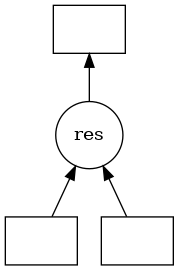

In [34]:
dask.visualize(dic,"res")

Las cajas representan datos, los círculos representan funciones que se ejecutan sobre tales datos y las flechas especifican cuáles funciones producen/consumen qué datos.

### Flujo de trabajo con *Dask collections*

En resumen en *Dask* seguimos un flujo como el siguiente dibujo.

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" heigth="400" width="400">

```{admonition} Observación
:class: tip

Para crear *task/dask graphs* podemos usar las *collections* o bien, definir nuestras propias.
 
```

```{admonition} Comentario

Si trabajamos con las *collections* será extraño que trabajemos a nivel de funciones `get`. Cada *collection* tiene un default scheduler y una función [compute](https://docs.dask.org/en/latest/scheduler-overview.html#using-compute-methods) que calcula el *output* de la *collection*.

```

### Ejemplo

[dask arrays](https://docs.dask.org/en/latest/array.html) y [dask dataframes](https://docs.dask.org/en/latest/dataframe.html) utilizan al *threaded scheduler* por *default* pero con `compute` puede cambiarse de *scheduler*.

In [35]:
import dask.array as da

In [36]:
x = da.arange(100)

In [37]:
print(x)

dask.array<arange, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>


In [38]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [39]:
print(type(x))

<class 'dask.array.core.Array'>


Llamamos a la función [dask.compute](https://docs.dask.org/en/latest/api.html#dask.compute). 

```{margin}

Por *default* el *dask array* utiliza el *threaded scheduler* para la ejecución de la *dask graph* asociada.

```

In [40]:
print(x.sum().compute())

4950


Podemos cambiar de *scheduler* especificando en `compute`:

In [41]:
print(x.sum().compute(scheduler="processes"))

4950


Por *default* `dask array` trabaja con *chunks*.

In [42]:
x = da.arange(100, chunks=10)

In [43]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(10,), chunktype=numpy.ndarray>

Por *default*, `dask array` trabaja de una forma *lazy*, esto es, `dask array` no calculará ningún resultado hasta que explícitamente se le dé la instrucción.

In [44]:
y = x.sum()

In [45]:
y

dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

Hasta este punto no se ha calculado la suma (cuyo resultado es un escalar). Después de llamar a `compute` se ejecuta la *task graph* para ejecución en paralelo (si se definió al *scheduler* para este tipo de ejecución).

In [46]:
print(y.compute())

4950


Y podemos visualizar la *task/dask graph* definida en `y` que es un *dask array*:

In [47]:
print(type(y))

<class 'dask.array.core.Array'>


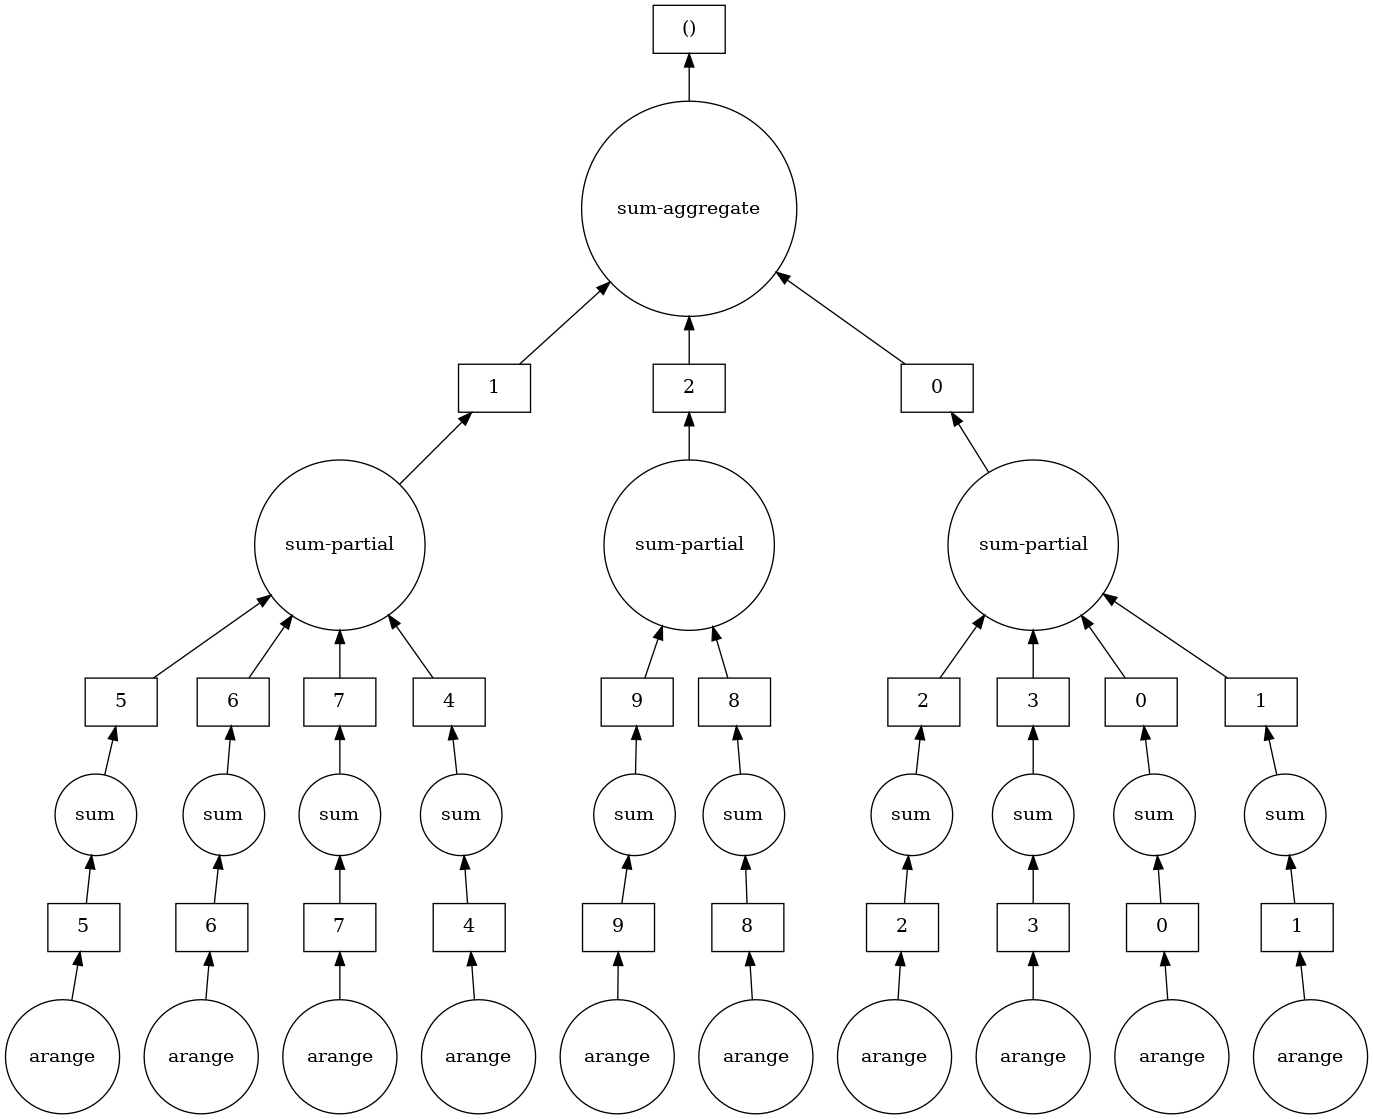

In [48]:
y.visualize()

Ver la API de *dask array* en [array api](https://docs.dask.org/en/latest/array-api.html) para más funcionalidad.

```{admonition} Comentario

*Dask* tiene una función [compute](https://docs.dask.org/en/latest/scheduler-overview.html#the-compute-function) más general que toma múltiples *collections* y regresa múltiples resultados. Esto combina grafos de cada *collection* de modo que resultados intermedios son compartidos. 

```

In [49]:
y = (x+1).sum()
z = (x+1).mean()

In [50]:
print(da.compute(y, z))

(5050, 50.5)


y aquí el resultado intermedio `x+1` sólo fue calculado una vez. Si hubiéramos hecho:

```
y.compute()
z.compute()
```

el resultado intermedio `x+1` hubiera sido calculado dos veces. Ésta función `compute` trabaja sobre cualquier *collection* y se encuentra en `dask.base`:

In [51]:
from dask.base import compute

In [52]:
print(compute is da.compute)

True


In [53]:
print(compute(y,z))

(5050, 50.5)


También se puede especificar para un *scheduler* `threaded` o `multiprocessing`, el número de *workers* en `compute`:

In [54]:
print(y.compute(num_workers=2))

5050


Ver [configuration](https://docs.dask.org/en/latest/scheduling.html#configuration) para otras formas de especificar al *scheduler*. Ver también [Delayed](https://docs.dask.org/en/latest/delayed.html) y [Custom Workloads with Dask Delayed](https://examples.dask.org/delayed.html) para otra opción diferente a los *dask array*'s, *dask dataframe*'s y *dask bag*'s para cómputo *lazy*.

### Ejemplo regla compuesta del rectángulo con `dask.array`

In [103]:
import numpy as np

In [104]:
f_np = lambda x: np.exp(-x**2)

In [105]:
def Rcf_dask_array(f,a,b,n, n_s_w, n_workers):
    """
    Compute numerical approximation using rectangle or mid-point
    method in an interval.
    Nodes are generated via formula: x_i = a+(i+1/2)h_hat for
    i=0,1,...,n-1 and h_hat=(b-a)/n
    Args:
    
        f (float): function expression of integrand.
        
        a (float): left point of interval.
        
        b (float): right point of interval.
        
        n (int): number of subintervals.
        
        n_s_w (int): number of subintervals per worker
        
        n_workers (int): number of workers
        
    Returns:
    
        sum_res (float): numerical approximation to integral
            of f in the interval a,b
    """
    h_hat = (b-a)/n
    aux_dask_array = da.linspace(a, b, n+1, chunks = n_s_w)
    nodes = (aux_dask_array[:-1]+aux_dask_array[1:])/2
    f_evaluated_in_nodes = f_np(nodes)
    res_sum = f_evaluated_in_nodes.sum().compute(num_workers=n_workers)
    return h_hat*res_sum

In [106]:
print(p, n_subintervals_per_subprocess)

64 156250


In [107]:
start_time=time.time()
res_rcf_dask_array = Rcf_dask_array(f_np,a,b,n, 
                                    n_subintervals_per_subprocess, 
                                    p)
end_time = time.time()

In [108]:
secs = end_time-start_time
print("Rcf_dask_array tomó",secs,"segundos" )

Rcf_dask_array tomó 0.1601552963256836 segundos


In [109]:
print(res_rcf_dask_array == approx(obj))

True


### [Dask distributed](https://github.com/dask/distributed)

* Es un paquete que extiende a [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) (`multiprocessing` es similar a `concurrent.futures`) y a *Dask* para clústers de tamaño mediano (alrededor de cientos de máquinas).

* Aunque el nombre *distributed* puede tomarse como que la ejecución sólo puede llevarse a cabo en clústers de máquinas, también puede utilizarse en nuestra máquina local. 

* Por razones como proveer acceso a una API asíncrona: [Futures](https://docs.dask.org/en/latest/futures.html), acceso a un *dashboard* diagnóstico y manejar mejor la *data locality* con múltiples procesos más eficientemente que con `dask.multiprocessing.get`, representa una **alternativa fuerte** a la generación de procesos locales vía `dask.multiprocessing`:  *The distributed scheduler described a couple sections below is often a better choice today than `dask.multiprocessing`...*

Tiene las siguientes características.

* *Low latency: Each task suffers about 1ms of overhead. A small computation and network roundtrip can complete in less than 10ms.*

* *Peer-to-peer data sharing: Workers communicate with each other to share data. This removes central bottlenecks for data transfer.*

* *Complex Scheduling: Supports complex workflows (not just map/filter/reduce) which are necessary for sophisticated algorithms used in nd-arrays, machine learning, image processing, and statistics.*

* *Data Locality: Scheduling algorithms cleverly execute computations where data lives. This minimizes network traffic and improves efficiency.*

* *Familiar APIs: Compatible with the [concurrent.futures](https://www.python.org/dev/peps/pep-3148/) API in the Python standard library. Compatible with dask API for parallel algorithms.*

Para ver más sobre el *distributed scheduler* ver [dask-architecture](https://distributed.dask.org/en/latest/#architecture).

### ¿[concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html)?

* Es un paquete para ejecución de *tasks* en paralelo.

* En `concurrent.futures` se trabaja con objetos de tipo valor `future` los cuales son resultados de cálculos que estarán disponibles en un futuro, de aquí el nombre de *future* y su cómputo **no** es *lazy* sino inmediato. 

* La obtención del *future* es asíncrona por lo que permite cómputo concurrente.


### Ejemplo

In [55]:
import time

In [56]:
def inc(x):
    time.sleep(1)
    return x+1

**Ejecución secuencial**

In [57]:
%%time
inputs = [1,2,3,4,5,6,7,8,9,10]
results=[]

for x in inputs:
    result=inc(x)
    results.append(result)

CPU times: user 949 µs, sys: 1.02 ms, total: 1.97 ms
Wall time: 10 s


In [58]:
print(results)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


**Ejecución con** `concurrent.futures`

In [59]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

In [60]:
executor = ProcessPoolExecutor(multiprocessing.cpu_count())

In [61]:
print(executor)

In [62]:
%%time
future = executor.submit(inc,3)

CPU times: user 39.7 ms, sys: 189 ms, total: 229 ms
Wall time: 218 ms


```{admonition} Observación
:class: tip

Obsérvese que se obtiene el `future` inmediatamente. Ver [submit](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.submit)

```

In [63]:
print(future)

<Future at 0x7fd2df547af0 state=running>


```{admonition} Observación
:class: tip

La ejecución del `future` se encuentra en algún subproceso del proceso principal. Obsérvese que tiene un estado *running*. Y después de un tiempo el estado ya es *finished*.

```

In [64]:
print(future)

<Future at 0x7fd2df547af0 state=running>


Para obtener el resultado hacemos:

In [65]:
print(future.result())

4


Entonces podemos hacer `submit` de varios cálculos de forma asíncrona con el objeto `executor` que devolverá *futures*:

In [66]:
%%time
inputs = [1,2,3,4,5,6,7,8,9,10]
futures=[]

for x in inputs:
    future=executor.submit(inc,x)
    futures.append(future)
    
results = [future.result() for future in futures]

CPU times: user 2.82 ms, sys: 3.09 ms, total: 5.92 ms
Wall time: 1.01 s


```{admonition} Comentario

El *statement* `results = [future.result() for future in futures]` bloquea la ejecución del proceso local hasta que todos los procesos finalizan la ejecución.
                                                  
```                                                  

```{admonition} Observación
:class: tip

Obsérvese que se redujo el tiempo pues la ejecución fue en paralelo por los subprocesos que ejecutaron `inc`.

```

In [67]:
print(results)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [68]:
executor.shutdown()

```{admonition} Comentarios

* También en `concurrent.futures` se tiene una función [map](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.map) para cómputo inmediato (no *lazy*) usando *futures* que soporta múltiples llamados a una función utilizando un *iterable*.

* Para una vista rápida a `concurrent.futures` ver: [Python: A quick introduction to the concurrent.futures module](http://masnun.com/2016/03/29/python-a-quick-introduction-to-the-concurrent-futures-module.html).

```

### *Client* de `dask.distributed`

El [Client](https://distributed.dask.org/en/latest/client.html) es el *entry point* para users de `dask.distributed`. Creamos un *distributed scheduler* al importar `Client`. Esta acción *override* cualquier configuración que se haya hecho del *scheduler*.

In [69]:
from dask.distributed import Client

In [70]:
client = Client()

```{admonition} Comentario

Al `Client` se le pueden pasar argumentos como número de *workers*, si se desean procesos o no, el límite de memoria a usar por cada proceso, entre otros.
                  
```                  

In [71]:
print(client)

<Client: 'tcp://127.0.0.1:45025' processes=8 threads=64, memory=251.89 GiB>


In [72]:
client

Client Scheduler: tcp://127.0.0.1:45025 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 251.89 GiB


Para ir al *dashboard* que se expone con [bokeh](https://docs.bokeh.org/en/latest/index.html) ir a la url con puerto `8787`.

```{admonition} Observación
:class: tip

Si se ejecuta con una imagen de *Docker*, revisar a qué puerto está mapeado el `8787`.

```

<img src="https://dl.dropboxusercontent.com/s/n5i7r4tp0saffmx/dask_1.png?dl=0" heigth="500" width="500">

y en el apartado de `workers`:

<img src="https://dl.dropboxusercontent.com/s/aqspobw9mmtw1tw/dask_2.png?dl=0" heigth="500" width="500">

Ver [Web Interface](http://distributed.dask.org/en/1.12.2/web.html) y [Diagnosing Performance](https://distributed.dask.org/en/latest/diagnosing-performance.html) para más sobre la información de diagnóstico que se junta en el dashboard.

```{admonition} Comentarios

* La línea anterior que contiene `Client`, configura un *scheduler* en el proceso local y varios procesos *workers* o *dask-workers* que corren un *thread* de ejecución (pueden correr más por *default*). Si se desea que los procesos *worker* estén contenidos en el proceso local puede usarse `Client(processes=False)`. Esta situación es preferible si se desea evitar comunicación *inter worker* y si nuestros cálculos están soltando el *GIL* (por ejemplo al usar *NumPy* o `dask.array`).


* Algunas opciones que pueden utilizarse con la línea de `Client` son:

* `Client(n_workers=4)`.

* `Client(threads_per_worker=2)`.

* `Client(memory_limit='10GB')`.

Ver [LocalCluster](https://docs.dask.org/en/latest/setup/single-distributed.html#distributed.deploy.local.LocalCluster) para opciones a usar en `Client` y [API](https://distributed.dask.org/en/latest/api.html) para la API con `Client`.

```

### Ejemplo regla compuesta del rectángulo con `map` y `gather`

In [73]:
def create_nodes_in_subintervals(my_id,a,b,h_hat,n,n_s_sub):
    begin = my_id*n_s_sub
    end = begin+n_s_sub
    h_hat = (b-a)/n
    nodes = []
    for i in range(begin,end):
        nodes.append(a+(i+1/2.0)*h_hat)
    return nodes

In [74]:
def evaluate_f_in_nodes_and_sum(nodes,f):
    sum_res = 0
    for node in nodes:
        sum_res+=f(node)
    return sum_res

In [75]:
%%time
futures_nodes = client.map(create_nodes_in_subintervals,range(p),
                           **{'a':a,
                              'b':b,
                              "h_hat":h_hat,
                              'n':n,
                              "n_s_sub":n_subintervals_per_subprocess}
                            )
futures_evaluated = client.map(evaluate_f_in_nodes_and_sum, futures_nodes,
                            **{'f':f}
                            )
results_gather = client.gather(futures_evaluated)
res_rcf_distributed = h_hat*sum(results_gather)

CPU times: user 110 ms, sys: 55.8 ms, total: 166 ms
Wall time: 1 s


In [76]:
print(res_rcf_distributed == approx(obj))

True


```{admonition} Comentarios

* Con `map` o `submit` se han enviado las *tasks* al *scheduler* a realizar. Ver [map](https://distributed.dask.org/en/latest/api.html), [submit](https://distributed.dask.org/en/latest/api.html#distributed.Client.submit) y [concurrent.futures](https://distributed.dask.org/en/latest/client.html#concurrent-futures). 

* Las ejecuciones `map` son muy rápidas e inmediatas pues se regresan *futures*.

* Los cálculos definidos por las funciones `create_nodes_in_subintervals` y `evaluate_f_in_nodes_and_sum` se ejecutan en cada *dask-worker* y a distintos tiempos. 

* Obsérvese que se puede hacer `map` o `submit` en *futures*. 

* Los resultados viven en los procesos *dask-workers*.

* Con `gather` se juntan los resultados (*futures*) en el proceso local.

* Podemos usar `gather` o `result` de los *futures*.

```

In [77]:
client.close()

### Ejemplo regla compuesta del rectángulo con `map` y `result`

In [78]:
client = Client(n_workers=multiprocessing.cpu_count(),
                threads_per_worker=1
               )  

In [79]:
client

Client Scheduler: tcp://127.0.0.1:35749 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 251.89 GiB


In [80]:
%%time
futures_nodes = client.map(create_nodes_in_subintervals,range(p),
                           **{'a':a,
                              'b':b,
                              "h_hat":h_hat,
                              'n':n,
                              "n_s_sub":n_subintervals_per_subprocess}
                            )
futures_evaluated = client.map(evaluate_f_in_nodes_and_sum, futures_nodes,
                                                       **{'f':f}
                            )

results = [future.result() for future in futures_evaluated]
res_rcf_distributed = h_hat*sum(results)

CPU times: user 428 ms, sys: 75.4 ms, total: 503 ms
Wall time: 630 ms


In [81]:
print(res_rcf_distributed == approx(obj))

True


### Gráfica de tiempo de ejecución vs número de procesos

In [82]:
err_np = []
n_cpus = []

In [83]:
def relative_error(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj)

In [84]:
def Rcf_dask(my_id,f,a,b,h_hat,n,n_s_sub):
    begin=my_id*n_s_sub
    end=begin+n_s_sub
    h_hat=(b-a)/n
    sum_res = 0
    for i in range(begin,end):
        x = a+(i+1/2)*h_hat
        sum_res += f(x)
    return sum_res

In [85]:
def myfun(cl,p,n_s_sub):
    futures_Rcf_dask = cl.map(Rcf_dask,range(p),
                              **{'f':f,
                                 'a':a,
                                 'b':b,
                                 "h_hat":h_hat,
                                 'n':n,
                                 "n_s_sub":n_s_sub}
                              ) 
    results_gather = cl.gather(futures_Rcf_dask)
    res_rcf_dask = h_hat*sum(results_gather)
    return relative_error(res_rcf_dask,obj)


```{margin}

Ejecutamos `close` para las creaciones de clientes anteriores.

```

In [86]:
client.close()

In [88]:
client

Client Scheduler: tcp://127.0.0.1:35749 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


**Primero revisamos errores relativos**

In [89]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        n_subintervals_per_subprocess = int(n/p)
        client = Client(n_workers=p,
                        threads_per_worker=1
                       )
        err_np.append(myfun(client,p,n_subintervals_per_subprocess))
        n_cpus.append(p)
        client.close()

In [90]:
print(err_np)

[4.99495021497577e-14, 1.4419945561090765e-14, 2.4231454911936028e-14, 5.886905610507158e-14, 1.3825308630736507e-14, 1.7690448678039188e-14, 3.716480814714115e-15, 3.86514004730268e-15, 2.527206954005598e-15, 2.973184651771292e-15, 2.229888488828469e-15, 2.6758661865941626e-15, 1.486592325885646e-15]


In [94]:
print(n_cpus)

[1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 64]


In [95]:
l=[]
n_cpus=[]

In [96]:
client.close()

In [97]:
client

Client Scheduler: tcp://127.0.0.1:36511 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [98]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        n_subintervals_per_subprocess = int(n/p)
        client = Client(n_workers=p,
                threads_per_worker=1
                       )
        start_time=time.time()
        futures_Rcf_dask = client.map(Rcf_dask,range(p),
                                      **{'f':f,
                                         'a':a,
                                         'b':b,
                                         "h_hat":h_hat,
                                         'n':n,
                                         "n_s_sub":n_subintervals_per_subprocess}
                                     )
        res_gather = client.gather(futures_Rcf_dask)
        end_time = time.time()
        secs = end_time-start_time
        l.append(secs)
        n_cpus.append(p)
        client.close()

In [99]:
print(l)

[3.701357364654541, 1.8432807922363281, 0.9091541767120361, 0.7361886501312256, 0.4691917896270752, 0.4330434799194336, 0.26079630851745605, 0.23067212104797363, 0.2382211685180664, 0.3052539825439453, 0.2685668468475342, 0.2464737892150879, 0.2692685127258301]


In [100]:
print(n_cpus)

[1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 64]


In [101]:
import matplotlib.pyplot as plt

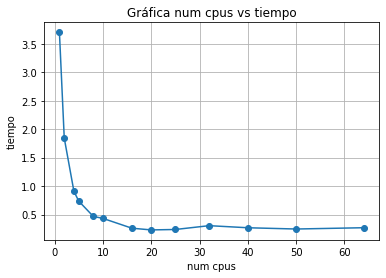

In [102]:
plt.plot(n_cpus,l,'o-')
plt.title('Gráfica num cpus vs tiempo')
plt.xlabel('num cpus')
plt.ylabel('tiempo')
plt.grid()
plt.show()

```{admonition} Ejercicio
:class: tip

Implementar la regla de Simpson compuesta con *Multiprocessing* y *Dask* en una máquina de AWS con las mismas características que la que se presenta en esta nota, medir tiempo de ejecución y realizar gráfica de tiempo vs num cpus.

```

## [Parallel](https://www.rdocumentation.org/packages/parallel/versions/3.6.2)

Entre las herramientas más populares en *R* para cómputo en paralelo se encuentran:

* [Simple Network Of Workstations: snow](https://www.rdocumentation.org/packages/snow/versions/0.4-3). Ya es una herramienta incluida en el paquete *Parallel*). Ver [liga](http://homepage.divms.uiowa.edu/~luke/R/cluster/cluster.html) para más información.

* [multicore](https://www.rdocumentation.org/packages/future/versions/1.15.1/topics/multicore). Funciona en la familia Unix pero no en Windows y ya es una herramienta incluida en el paquete *Parallel*.

* [foreach](https://www.rdocumentation.org/packages/foreach/versions/1.4.7/topics/foreach). Hay ventajas al usarse con el paquete [iterators](https://www.rdocumentation.org/packages/iterators/versions/1.0.12).

* [Rmpi](https://www.rdocumentation.org/packages/Rmpi/versions/0.6-9). Paralelización en SMC y en SMD.


```{admonition} Comentarios

* Las primeras dos son parte del paquete [parallel](https://www.rdocumentation.org/packages/parallel/versions/3.6.2) el cual está incluido en la instalación de *R* desde la versión `2.14.0`.

* Los cuatro paquetes de arriba emplean un paradigma de programación en paralelo del tipo *scatter/gather*: se tienen múltiples instancias de *R* corriendo al mismo tiempo en un clúster de máquinas o en una máquina *multicore*. Una de las instancias se le denomina *manager*  y las restantes *workers*. El cómputo en paralelo procede como sigue:

    * **scatter**: *manager* descompone el cómputo a realizar en *chunks* y envía (*scatters*) los *chunks* a *workers*.
    
    * **chunk computation**: *workers* hacen el cómputo en cada *chunk* y envían de regreso los resultados a *manager*.
    
    * **gather**: *manager* recibe (*gathers*) los resultados y los combina para resolver el problema.

```

### Ejemplo

In [1]:
library(parallel)

En *Parallel* tenemos la función `detectCores` que como su nombre lo indica obtiene el número de CPU's en nuestra máquina.

In [2]:
p <- detectCores()

In [3]:
p

[1] 64

Usamos `makeCluster` para iniciar el *snow cluster*:

In [4]:
cl <- makeCluster(p)

La línea anterior crea `p` *workers* y cada *worker* es un proceso de *R* (al igual que el proceso *manager*) que corren en la misma máquina.

```{admonition} Comentario

El nombre de clúster en *snow* hace referencia al conjunto de *workers* y no a máquinas físicas. El objeto `cl` contiene información de *workers* y es de clase `cluster`.

```

In [5]:
print(class(cl))

[1] "SOCKcluster" "cluster"    


La comunicación entre *manager* y *workers* por *default* en `makeCluster` es vía [network sockets](https://en.wikipedia.org/wiki/Network_socket) y es posible crear un clúster de máquinas físicas conectadas vía una network. 

In [6]:
print(cl)

socket cluster with 64 nodes on host ‘localhost’


#### clusterApply

En *Parallel* se tiene la función [clusterApply](https://www.rdocumentation.org/packages/parallel/versions/3.6.2/topics/clusterApply) para ejecución en paralelo de una función aplicada a cada elemento de una lista: *manager* envía `lista[1]` a `cl[1]`, `lista[2]` a `cl[2]`,...,`lista[p]` a `cl[p]`. 

Además, si el número de elementos de la lista es mayor que el número de *workers* entonces `clusterApply` realiza una asignación tipo *round robin*: por ejemplo, si la lista tiene $4$ elementos y se tienen $2$ *workers* entonces `clusterApply` le envía a *worker1* el elemento de la primera posición de la lista, a *worker2* el segundo elemento. Después que *worker1* finaliza el procesamiento, `clusterApply` le envía la tercera posición y al terminar *worker2* del procesamiento, `clusterApply` le envía la cuarta posición (`clusterApply` aprovecha la característica que tiene *R* de reciclar operaciones).

In [7]:
print(clusterApply(cl, 1:p,function(dummy)print("Hello world!")))

[[1]]
[1] "Hello world!"

[[2]]
[1] "Hello world!"

[[3]]
[1] "Hello world!"

[[4]]
[1] "Hello world!"

[[5]]
[1] "Hello world!"

[[6]]
[1] "Hello world!"

[[7]]
[1] "Hello world!"

[[8]]
[1] "Hello world!"

[[9]]
[1] "Hello world!"

[[10]]
[1] "Hello world!"

[[11]]
[1] "Hello world!"

[[12]]
[1] "Hello world!"

[[13]]
[1] "Hello world!"

[[14]]
[1] "Hello world!"

[[15]]
[1] "Hello world!"

[[16]]
[1] "Hello world!"

[[17]]
[1] "Hello world!"

[[18]]
[1] "Hello world!"

[[19]]
[1] "Hello world!"

[[20]]
[1] "Hello world!"

[[21]]
[1] "Hello world!"

[[22]]
[1] "Hello world!"

[[23]]
[1] "Hello world!"

[[24]]
[1] "Hello world!"

[[25]]
[1] "Hello world!"

[[26]]
[1] "Hello world!"

[[27]]
[1] "Hello world!"

[[28]]
[1] "Hello world!"

[[29]]
[1] "Hello world!"

[[30]]
[1] "Hello world!"

[[31]]
[1] "Hello world!"

[[32]]
[1] "Hello world!"

[[33]]
[1] "Hello world!"

[[34]]
[1] "Hello world!"

[[35]]
[1] "Hello world!"

[[36]]
[1] "Hello world!"

[[37]]
[1] "Hello world!"

[[38]]
[1]

In [8]:
print(clusterApply(cl, 1:5,function(dummy)print("Hello world!")))

[[1]]
[1] "Hello world!"

[[2]]
[1] "Hello world!"

[[3]]
[1] "Hello world!"

[[4]]
[1] "Hello world!"

[[5]]
[1] "Hello world!"



```{admonition} Observación
:class: tip

Obsérvese que el resultado de `clusterApply` es una lista.

```

### Ejemplo de pasar argumentos vía `clusterExport`

`clusterExport` nos permite enviar valores de variables definidas en el *workspace global* de *manager* hacia los *workspaces* de cada *worker* bajo los mismos nombres de variables:

In [9]:
s <- "Hola mundo!"

In [10]:
clusterExport(cl,'s')

In [11]:
print(clusterApply(cl, 1:p,function(dummy)print(s)))

[[1]]
[1] "Hola mundo!"

[[2]]
[1] "Hola mundo!"

[[3]]
[1] "Hola mundo!"

[[4]]
[1] "Hola mundo!"

[[5]]
[1] "Hola mundo!"

[[6]]
[1] "Hola mundo!"

[[7]]
[1] "Hola mundo!"

[[8]]
[1] "Hola mundo!"

[[9]]
[1] "Hola mundo!"

[[10]]
[1] "Hola mundo!"

[[11]]
[1] "Hola mundo!"

[[12]]
[1] "Hola mundo!"

[[13]]
[1] "Hola mundo!"

[[14]]
[1] "Hola mundo!"

[[15]]
[1] "Hola mundo!"

[[16]]
[1] "Hola mundo!"

[[17]]
[1] "Hola mundo!"

[[18]]
[1] "Hola mundo!"

[[19]]
[1] "Hola mundo!"

[[20]]
[1] "Hola mundo!"

[[21]]
[1] "Hola mundo!"

[[22]]
[1] "Hola mundo!"

[[23]]
[1] "Hola mundo!"

[[24]]
[1] "Hola mundo!"

[[25]]
[1] "Hola mundo!"

[[26]]
[1] "Hola mundo!"

[[27]]
[1] "Hola mundo!"

[[28]]
[1] "Hola mundo!"

[[29]]
[1] "Hola mundo!"

[[30]]
[1] "Hola mundo!"

[[31]]
[1] "Hola mundo!"

[[32]]
[1] "Hola mundo!"

[[33]]
[1] "Hola mundo!"

[[34]]
[1] "Hola mundo!"

[[35]]
[1] "Hola mundo!"

[[36]]
[1] "Hola mundo!"

[[37]]
[1] "Hola mundo!"

[[38]]
[1] "Hola mundo!"

[[39]]
[1] "Hola mund

**¿Qué pasa si mi `clusterExport` está dentro de una función?**

In [12]:
myfun <- function(){
    s_local<-"Hola mundo! usando variable local a myfun"
    clusterExport(cl,"s_local")
    print(clusterApply(cl, 1:p,function(dummy)print(s_local)))
}

In [13]:
print(myfun())

ERROR: Error in get(name, envir = envir): object 's_local' not found


Lo anterior lo podemos resolver con *superassignment*. Ver [What does the "<<-" operator mean?](https://stat.ethz.ch/pipermail/r-help/2011-April/275905.html) y [how-do-you-use-scoping-assignment-in-r](https://stackoverflow.com/questions/2628621/how-do-you-use-scoping-assignment-in-r).

In [14]:
myfun2 <- function(){
    s_global <<- "Hola mundo! usando superassignment en mifun2" #<<- superassignment
    clusterExport(cl,"s_global")
    clusterApply(cl, 1:p,function(dummy)print(s_global))
}

In [15]:
print(myfun2())

[[1]]
[1] "Hola mundo! usando superassignment en mifun2"

[[2]]
[1] "Hola mundo! usando superassignment en mifun2"

[[3]]
[1] "Hola mundo! usando superassignment en mifun2"

[[4]]
[1] "Hola mundo! usando superassignment en mifun2"

[[5]]
[1] "Hola mundo! usando superassignment en mifun2"

[[6]]
[1] "Hola mundo! usando superassignment en mifun2"

[[7]]
[1] "Hola mundo! usando superassignment en mifun2"

[[8]]
[1] "Hola mundo! usando superassignment en mifun2"

[[9]]
[1] "Hola mundo! usando superassignment en mifun2"

[[10]]
[1] "Hola mundo! usando superassignment en mifun2"

[[11]]
[1] "Hola mundo! usando superassignment en mifun2"

[[12]]
[1] "Hola mundo! usando superassignment en mifun2"

[[13]]
[1] "Hola mundo! usando superassignment en mifun2"

[[14]]
[1] "Hola mundo! usando superassignment en mifun2"

[[15]]
[1] "Hola mundo! usando superassignment en mifun2"

[[16]]
[1] "Hola mundo! usando superassignment en mifun2"

[[17]]
[1] "Hola mundo! usando superassignment en mifun2"

[[18]]

O bien con `environment()`:

In [16]:
myfun3 <- function(s_global2){
    clusterExport(cl,"s_global2")
    clusterApply(cl, 1:p,function(dummy)print(s_global2))
}

In [17]:
print(myfun3("Hola mundo! usando variable local a mifun3"))

ERROR: Error in get(name, envir = envir): object 's_global2' not found


In [18]:
myfun4<-function(s_global2){
    clusterExport(cl,"s_global2", envir=environment())
    clusterApply(cl, 1:p,function(dummy)print(s_global2))
}

In [19]:
print(myfun4("Hola mundo! usando environment()"))

[[1]]
[1] "Hola mundo! usando environment()"

[[2]]
[1] "Hola mundo! usando environment()"

[[3]]
[1] "Hola mundo! usando environment()"

[[4]]
[1] "Hola mundo! usando environment()"

[[5]]
[1] "Hola mundo! usando environment()"

[[6]]
[1] "Hola mundo! usando environment()"

[[7]]
[1] "Hola mundo! usando environment()"

[[8]]
[1] "Hola mundo! usando environment()"

[[9]]
[1] "Hola mundo! usando environment()"

[[10]]
[1] "Hola mundo! usando environment()"

[[11]]
[1] "Hola mundo! usando environment()"

[[12]]
[1] "Hola mundo! usando environment()"

[[13]]
[1] "Hola mundo! usando environment()"

[[14]]
[1] "Hola mundo! usando environment()"

[[15]]
[1] "Hola mundo! usando environment()"

[[16]]
[1] "Hola mundo! usando environment()"

[[17]]
[1] "Hola mundo! usando environment()"

[[18]]
[1] "Hola mundo! usando environment()"

[[19]]
[1] "Hola mundo! usando environment()"

[[20]]
[1] "Hola mundo! usando environment()"

[[21]]
[1] "Hola mundo! usando environment()"

[[22]]
[1] "Hola mundo

### Ejemplo regla compuesta del rectángulo con `clusterApply`

In [20]:
library(microbenchmark)
library(tictoc)

In [21]:
f <- function(x)exp(-x**2)

In [22]:
a <- 0
b <- 1
n <- 10**7
h_hat <- (b-a)/n

In [23]:
n_subintervals_per_subprocess <- as.integer(n/p)

```{admonition} Comentario

`n_subintervals_per_subprocess` es el número de subintervalos por *core*. Se asume que `n` es divisible por `p`. Si no se cumple esto, se puede definir `n_subintervals_per_subprocess <- int(n/p)` habiendo definido `n` primero y redefinir `n` como: `n <- p*n_subintervals_per_subprocess`
              
```              

In [24]:
relative_error <- function(aprox,obj)abs(aprox-obj)/abs(obj)

In [25]:
sprintf("número de subintervalos: %d",n)

[1] "número de subintervalos: 10000000"

In [26]:
sprintf("número de subintervalos por proceso: %d",n_subintervals_per_subprocess)

[1] "número de subintervalos por proceso: 156250"

In [27]:
Rcf_parallel_cl_apply <- function(my_id){
    begin <- my_id*n_subintervals_per_subprocess
    end <- begin+n_subintervals_per_subprocess
    sum_res <- 0
    for(j in begin:(end-1)){
        x <- a+(j+1/2)*h_hat
        sum_res <- sum_res+f(x)
    }
    sum_res    
}

In [28]:
clusterExport(cl,c("n_subintervals_per_subprocess",'a','f',"h_hat"))

Utilizamos la función `Reduce` y la función `sum` a la lista que resulta de `clusterApply`: 

In [29]:
tic("regla Rcf_parallel_cl_apply")
result_cl_apply  <- clusterApply(cl,0:(p-1),Rcf_parallel_cl_apply)
res_rcf_cl_apply <- h_hat*Reduce(sum,result_cl_apply)
toc()

regla Rcf_parallel_cl_apply: 0.562 sec elapsed


In [30]:
obj <- integrate(Vectorize(f),a,b)

In [31]:
print(relative_error(res_rcf_cl_apply,obj$value))

[1] 1.486592e-15


La encapsulamos en una función para pasarla a `microbenchmark`:

In [32]:
clapply <- function(cl,p){
    result_cl_apply <- clusterApply(cl,0:(p-1),Rcf_parallel_cl_apply)
    res_rcf_cl_apply <- h_hat*Reduce(sum,result_cl_apply)
}

In [33]:
mbk<-microbenchmark(
    clapply(cl,p),
    times=10
    )

In [34]:
print(mbk)

Unit: milliseconds
           expr      min       lq     mean   median       uq     max neval
 clapply(cl, p) 274.0143 299.3502 335.1274 322.0482 361.4857 457.578    10


### Ejemplo regla compuesta del rectángulo con `clusterSplit`

La función `clusterSplit` divide una secuencia en *chunks* de subsecuencias consecutivas. El número de *chunks* que regresa es igual al número de *workers*. `clusterSplit` intenta que los *chunks* sean similares en longitud y la división se realiza en *manager*.

En la siguiente implementación se recibe un `chunk` de nodos.

In [35]:
Rcf_parallel_cl_split<-function(chunk){
    sum_res <- 0
    for(x in chunk){
        sum_res <- sum_res+f(x)
    }
    sum_res    
}

In [36]:
tic()
#chunks for nodes using clusterSplit:
chunks <- clusterSplit(cl,vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1)))
#call clusterApply
result_cl_apply <- clusterApply(cl,chunks,Rcf_parallel_cl_split)
res_rcf_cl_split <- h_hat*Reduce(sum,result_cl_apply)
toc()

9.949 sec elapsed


In [37]:
print(relative_error(res_rcf_cl_split,obj$value))

[1] 2.824525e-15


En la siguiente implementación, se divide en chunks la secuencia: `0,1,...,n-1`:

In [38]:
Rcf_parallel_cl_split_2 <- function(chunk){
    n_s_sub <- length(chunk)
    begin <- chunk[1]
    end <- begin+n_s_sub
    sum_res <- 0
    for(j in begin:(end-1)){
        x <- a+(j+1/2)*h_hat
        sum_res <- sum_res+f(x)
    }
    sum_res    
}

In [39]:
tic()
#se crean los chunks de la secuencia: 0,1,...,n-1
chunks <- clusterSplit(cl,0:(n-1)) 
result_cl_apply <- clusterApply(cl,chunks,Rcf_parallel_cl_split_2)
res_rcf_cl_split_2 <- h_hat*Reduce(sum,result_cl_apply)
toc()

1.538 sec elapsed


In [40]:
print(relative_error(res_rcf_cl_split_2,obj$value))

[1] 2.824525e-15


Medimos tiempos con *Microbenchmark*.

In [41]:
clapply2 <- function(cl){
    chunks <- clusterSplit(cl,vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1))) 
    result_cl_apply <- clusterApply(cl,chunks,Rcf_parallel_cl_split)
    res_rcf_cl_split <- h_hat*Reduce(sum,result_cl_apply)
}

In [42]:
clapply3 <- function(cl){
    chunks <- clusterSplit(cl,0:(n-1))
    result_cl_apply <- clusterApply(cl,chunks,Rcf_parallel_cl_split_2)
    res_rcf_cl_split_2 <- h_hat*Reduce(sum,result_cl_apply)
}

In [43]:
mbk<-microbenchmark(
    clapply(cl,p),
    clapply2(cl),
    clapply3(cl),
    times=10
    )

In [44]:
print(mbk)

Unit: milliseconds
           expr       min        lq       mean    median       uq        max
 clapply(cl, p)  279.1311  282.8535   305.9289  294.0048  325.548   371.0334
   clapply2(cl) 9692.8472 9737.9523 10064.3089 9856.9876 9932.777 12093.3270
   clapply3(cl) 1341.8627 1463.4982  1484.6908 1478.0374 1539.323  1618.6653
 neval
    10
    10
    10


### Gráfica de tiempo de ejecución vs número de procesos

In [45]:
library(ggplot2)

Una buena práctica es detener el clúster:

*It is good practice to shut down the workers by calling stopCluster: however the workers will terminate themselves once the socket on which they are listening for commands becomes unavailable, which it should if the master R session is completed (or its process dies).*

In [46]:
stopCluster(cl)

En lo siguiente se utiliza `Rcf_parallel_cl_apply` pues tuvo el menor tiempo de ejecución. Usaremos ésta implementación para realizar la gráfica variando el número de procesos de $1$ hasta `detectCores()`.

In [47]:
myfun <- function(cl,p){
    result_apply <- clusterApply(cl,0:(p-1),Rcf_parallel_cl_apply)
    res_rcf_cl_apply <- h_hat*Reduce(sum,result_apply)
}

In [48]:
dim <- sum(n%%(1:detectCores())==0)

In [49]:
err_vec <- vector("double", dim)
n_cpus <- vector("integer",dim)

In [50]:
i<-1
for(p in 1:detectCores()){
    if(n%%p==0){
        n_subintervals_per_subprocess <- n/p
        cl <- makeCluster(p)
        clusterExport(cl,c('a','f',"h_hat","n_subintervals_per_subprocess"))
        res_my_fun <- myfun(cl,p)
        err_vec[i] <- relative_error(res_my_fun, obj$value)
        n_cpus[i] <- p
        stopCluster(cl)
        i <- i+1
    }
}

In [51]:
print(err_vec)

 [1] 4.994950e-14 1.441995e-14 2.423145e-14 5.886906e-14 1.382531e-14
 [6] 1.769045e-14 3.716481e-15 3.865140e-15 2.527207e-15 2.973185e-15
[11] 2.229888e-15 2.675866e-15 1.486592e-15


In [52]:
print(n_cpus)

 [1]  1  2  4  5  8 10 16 20 25 32 40 50 64


In [53]:
vector_with_time_medians <- vector("double", dim)
n_cpus <- vector("integer",dim)

In [54]:
i<-1
for(p in 1:detectCores()){
    if(n%%p==0){
        n_subintervals_per_subprocess <- n/p
        cl <- makeCluster(p)
        clusterExport(cl,c('a','f',"h_hat","n_subintervals_per_subprocess"))
        df <- print(microbenchmark(myfun(cl,p),times=10,unit="s"))
        stopCluster(cl)
        vector_with_time_medians[i] <- df$median
        n_cpus[i] <- p
        i <- i+1
    }
}

Unit: seconds
         expr      min       lq     mean   median       uq      max neval
 myfun(cl, p) 6.880437 6.912525 6.962728 6.951347 6.969166 7.092888    10
Unit: seconds
         expr      min       lq     mean   median       uq     max neval
 myfun(cl, p) 3.521054 3.528644 3.550711 3.537149 3.561584 3.63593    10
Unit: seconds
         expr      min      lq     mean   median       uq      max neval
 myfun(cl, p) 1.810182 1.84642 1.868893 1.855109 1.877132 1.992167    10
Unit: seconds
         expr      min       lq     mean   median       uq     max neval
 myfun(cl, p) 1.497631 1.503919 1.539663 1.513827 1.561826 1.68751    10
Unit: seconds
         expr       min        lq   mean    median       uq      max neval
 myfun(cl, p) 0.9574237 0.9681314 0.9938 0.9926238 1.002309 1.084198    10
Unit: seconds
         expr       min        lq      mean    median        uq       max neval
 myfun(cl, p) 0.7567488 0.7752932 0.8005973 0.7915049 0.8226106 0.8705034    10
Unit: seconds
      

In [55]:
print(vector_with_time_medians)

 [1] 6.9513466 3.5371493 1.8551087 1.5138267 0.9926238 0.7915049 0.5042411
 [8] 0.6444210 0.5821805 0.5106894 0.4660017 0.3503937 0.3519018


In [56]:
print(n_cpus)

 [1]  1  2  4  5  8 10 16 20 25 32 40 50 64


In [57]:
gg<-ggplot()

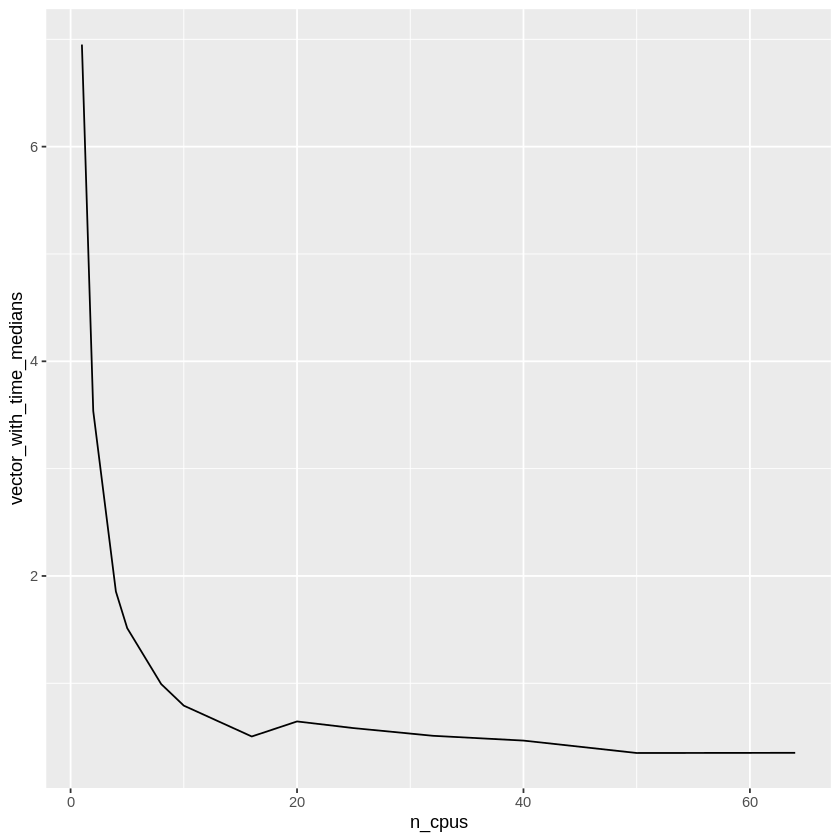

In [58]:
gg+
geom_line(aes(x=n_cpus,y=vector_with_time_medians))

```{admonition} Ejercicio
:class: tip

Implementar la regla de Simpson compuesta con *Parallel* en una máquina de AWS con las mismas características que la que se presenta en esta nota, medir tiempo de ejecución y realizar gráfica de tiempo vs num cpus.

```

## Referencias de interés

* [Use cases with dask](https://stories.dask.org/en/latest/)

* [dask-tutorial](https://github.com/dask/dask-tutorial)

* [matthew-rocklin-blog](http://matthewrocklin.com/blog/). Ver [Towards-OutOfCore-ND-Arrays-Slicing-and-Stacking](http://matthewrocklin.com/blog/work/2015/02/13/Towards-OOC-Slicing-and-Stacking). [Matthew Rocklin: Dask: out of core arrays with task scheduling](https://www.youtube.com/watch?v=ieW3G7ZzRZ0)

* En *dask* se hace referencia al uso de funciones *pure*. Ver: [Pure Functions by Default](https://distributed.dask.org/en/latest/client.html#pure-functions-by-default) y [Function Purity](https://toolz.readthedocs.io/en/latest/purity.html) para ejemplos de funciones *pure*.

* En [Dask JupyterLab Extension](https://www.youtube.com/watch?v=EX_voquHdk0) se muestra cómo instalar la extensión en jupyterlab para *Dask*.

* [snow Simplified](http://www.sfu.ca/~sblay/R/snow.html)

* [Using foreach and iterators for manual parallel execution](https://docs.microsoft.com/en-us/machine-learning-server/r/how-to-revoscaler-distributed-computing-foreach)

* Paquetes de *R* que ayudan al cómputo paralelo y concurrente: [future](https://www.rdocumentation.org/packages/future/versions/1.21.0), [Launching tasks with future ](https://rstudio.github.io/promises/articles/futures.html) y [furrr](https://github.com/DavisVaughan/furrr)

```{admonition} Ejercicios
:class: tip

1.Resuelve los ejercicios y preguntas de la nota.
```


**Preguntas de comprehensión:**

1)Menciona diferencias que surgen en un programa que se ejecuta en un sistema de memoria compartida contra los que se ejecutan en un sistema de memoria distribuida.

2)¿A qué se le llama no determinismo y da un ejemplo en el que esto surge en un sistema de memoria compartida?

3)¿Qué es una *critical section*? ¿qué es una *race condition*? ¿cómo se puede lidiar con las *critical sections*?

4)¿Cuál es la terminología para nombrar a las variables que pueden ser accesadas por todos los *threads* y para las variables que sólo pueden ser accesadas por un *thread*?

**Referencias:**

1. P. Pacheco, An Introduction to Parallel Programming, Morgan Kaufmann, 2011.

2. M. Gorelick, I. Ozsvald, High Performance Python, O'Reilly Media, 2014.

3. N. Matloff, Parallel Computing for Data Science. With Examples in R, C++ and CUDA, 2014.

4. B. W. Kernighan, D. M. Ritchie, The C Programming Language, Prentice Hall Software Series, 1988

5. [C/extensiones_a_C/openMP](https://github.com/palmoreck/programming-languages/tree/master/C/extensiones_a_C/openMP)
